In [1]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# sys.pathの設定
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

double_convolution_network

In [5]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

class DoubleConvNet:
  # conv - relu - pool - conv - relu - pool - affine - relu - affine - softmax で構成
  def __init__(self, input_dim=(1, 28, 28), 
               conv_param_1={'filter_num': 10, 'filter_size': 7, 'pad': 1, 'stride': 1},
               conv_param_2={'filter_num': 20, 'filter_size': 3, 'pad': 1, 'stride': 1},
               hidden_size=100, output_size=10, weight_init_std=0.01):

    conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) / conv_param_1['stride'] + 1
    conv_output_size_2 = (conv_output_size_1 / 2 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) / conv_param_2['stride'] + 1        
    pool_output_size = int(conv_param_2['filter_num'] * (conv_output_size_2 / 2) * (conv_output_size_2 / 2))        

    # 重みの初期化
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
    self.params['b1'] = np.zeros(conv_param_1['filter_num'])
    self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
    self.params['b2'] = np.zeros(conv_param_2['filter_num'])
    self.params['W3'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b3'] = np.zeros(hidden_size)
    self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b4'] = np.zeros(output_size)

    # レイヤの生成
    self.layers = OrderedDict()
    self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
    self.layers['Relu1'] = layers.Relu()
    self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
    self.layers['Relu2'] = layers.Relu()
    self.layers['Pool2'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
    self.layers['Relu3'] = layers.Relu()
    self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])

    self.last_layer = layers.SoftmaxWithLoss()

  def predict(self, x):
    for key in self.layers.keys():
        x = self.layers[key].forward(x)
    return x
        
  def loss(self, x, d):
    y = self.predict(x)
    return self.last_layer.forward(y, d)

  def accuracy(self, x, d, batch_size=100):
    if d.ndim != 1 : d = np.argmax(d, axis=1)
        
    acc = 0.0
        
    for i in range(int(x.shape[0] / batch_size)):
        tx = x[i*batch_size:(i+1)*batch_size]
        td = d[i*batch_size:(i+1)*batch_size]
        y = self.predict(tx)
        y = np.argmax(y, axis=1)
        acc += np.sum(y == td) 
        
    return acc / x.shape[0]

  def gradient(self, x, d):
    # forward
    self.loss(x, d)
        
    # backward
    dout = 1
    dout = self.last_layer.backward(dout)
    layers = list(self.layers.values())
        
    layers.reverse()
    for layer in layers:
        dout = layer.backward(dout)

    # 設定
    grad = {}
    grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
    grad['W2'], grad['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
    grad['W3'], grad['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grad['W4'], grad['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

    return grad




Generation: 10.正答率（train) = 0.04
             :10.正答率(test) =0.099
Generation: 20.正答率（train) = 0.18
             :20.正答率(test) =0.295
Generation: 30.正答率（train) = 0.56
             :30.正答率(test) =0.51
Generation: 40.正答率（train) = 0.65
             :40.正答率(test) =0.602
Generation: 50.正答率（train) = 0.66
             :50.正答率(test) =0.628
Generation: 60.正答率（train) = 0.64
             :60.正答率(test) =0.676
Generation: 70.正答率（train) = 0.75
             :70.正答率(test) =0.7
Generation: 80.正答率（train) = 0.76
             :80.正答率(test) =0.742
Generation: 90.正答率（train) = 0.7
             :90.正答率(test) =0.776
Generation: 100.正答率（train) = 0.78
             :100.正答率(test) =0.758


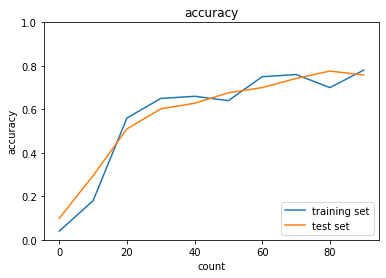

In [7]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]

network = DoubleConvNet(input_dim=(1, 28, 28), 
                        conv_param_1={'filter_num': 10, 'filter_size': 7, 'pad': 1, 'stride':1},
                        conv_param_2={'filter_num': 20, 'filter_size': 3, 'pad': 1, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
optimizer = optimizer.Adam()

iters_num = 100
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  optimizer.update(network.params, grad)

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)


  if (i + 1) % plot_interval == 0:
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()
